# CS733: Module 6 Assignment: Transformer Models for Text Classification and Language Modeling
**Task 2: Setting Up the Transformer Decoder for Language Modeling**

AJ Broderick *(UIN 01244170)* \
abrod006@odu.edu

### Load all needed libraries and packages

In [3]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import os
import io
import re
import math
from tqdm.notebook import trange, tqdm

import kagglehub
from sklearn.model_selection  import train_test_split
import random

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from torch.distributions import Categorical

# from torchtext.datasets import WikiText2, EnWik9, AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
from torch.hub import load_state_dict_from_url
from torchtext.data.functional import sentencepiece_tokenizer, load_sp_model

torch.backends.cuda.matmul.allow_tf32 = True

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/opt/conda/lib/python3.7/site-packages/sklearn/_distributor_init.py:25: FutureWarning: 
USE_DAAL4PY_SKLEARN variable is deprecated for Intel(R) Extension for Scikit-learn
and will be delete in the 2022.1 release.
Please, use new construction of global patching:
python sklearnex.glob patch_sklearn
Read more: https://intel.github.io/scikit-learn-intelex/global_patching.html
  FutureWarning)


In [4]:
%matplotlib inline

### Loading data and prepartion of model
Load file location from Kaggle\
[Wikipedia Sentences](https://www.kaggle.com/datasets/mikeortman/wikipedia-sentences/data)

In [5]:
wiki_path = kagglehub.dataset_download("mikeortman/wikipedia-sentences")
wikisent_file = (wiki_path + '/wikisent2.txt')

with open(wikisent_file, 'r') as f:
    sentences = f.read().splitlines()
    sentences = list(map(lambda x: x.lower(), sentences))

In [6]:
learning_rate = 1e-4
nepochs = 5
batch_size = 128
max_len = 32

In [7]:
seed = 42
random.seed(seed)
text = random.sample(sentences,200000) 
train, test = train_test_split(text, test_size=0.2, random_state=seed)
train_df = DataFrame(train)

In [8]:
data_loader_train = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)
data_loader_test = DataLoader(test, batch_size=200)

### Create CustomDataset & Apply to data

In [10]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.df = DataFrame(data, columns = ['text'])
        
        # self.df.rename(columns={"0": "text"})
        
        self.df['text'] = self.df['text'].str.replace(r'\\n|\\|\\r|\\r\\n|\n|"', ' ', regex=True)
        self.df['text'] = self.df['text'].replace({' #39;': "'",' #38;': "&",' #36;': "$",' #151;': "-"},regex=True)

    def __getitem__(self, idx):
        text = self.df.loc[index]["text"].lower()
        
        return text
    
    def __len__(self):
        return len(self.data)

In [11]:
train_data = CustomDataset(train)
test_data = CustomDataset(test)

### Data processing and Tokenization

In [12]:
path = "/home/abrod006/CS733"

with open('data.txt', 'w') as fp:
    pass

train_df.to_csv('train_data.csv')

In [13]:
# Write training data .csv into text file created before
with open(os.path.join(path, "train_data.csv")) as f:
    with open(os.path.join(path,"data.txt"), 'w') as fp:
        for i, line in enumerate(f):
            text_only = "".join(line.split(",")[1:])
            filtered = re.sub(r'\\|\\n|;', ' ', text_only.replace('"', ' ').replace('\n', ' ')) # remove newline characters
            filtered = filtered.replace(' #39;', "'")
            filtered = filtered.replace(' #38;', "&")
            filtered = filtered.replace(' #36;', "$")
            filtered = filtered.replace(' #151;', "-")

            fp.write(filtered.lower() + "\n")

In [ ]:
from torchtext.data.functional import generate_sp_model

generate_sp_model(os.path.join(path,"data.txt"), vocab_size=20000, model_prefix='wikipedia')

In [14]:
def yield_tokens(file_path):
    with io.open(file_path, encoding='utf-8') as f:
        for line in f:
            yield [line.split("\t")[0]]

vocab = build_vocab_from_iterator(yield_tokens("wikipedia.vocab"), specials=['<pad>', '<sos>', '<eos>', '<unk>'],special_first=True)

vocab.set_default_index(vocab['<unk>'])

In [15]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-specical token with <pad>.
    
    Args:
        prob (float): probability of dropping a token
        pad_token (int): index for the <pad> token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        # Randomly sample a bernoulli distribution with p=prob
        # to create a mask where 1 means we will replace that token
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        # only replace if the token is not a special token
        can_drop = (sample >= self.num_special).long()
        mask = mask * can_drop
        
        replace_with = (self.pad_token * torch.ones_like(sample)).long()
        
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

In [16]:
train_tranform = T.Sequential(
    T.SentencePieceTokenizer("wikipedia.model"),
    T.VocabTransform(vocab=vocab),
    T.AddToken(1, begin=True),
    T.Truncate(max_seq_len=max_len),
    T.AddToken(2, begin=False),
    T.ToTensor(padding_value=0),
)

gen_tranform = T.Sequential(
    T.SentencePieceTokenizer("wikipedia.model"),
    T.VocabTransform(vocab=vocab),
    T.AddToken(1, begin=True),
    T.ToTensor(padding_value=0)
)

In [17]:
text = next(iter(data_loader_train))
index = 0
input_tokens = train_tranform(list(text))
print("SENTENCE:")
print(text[index])

print()
print("TOKENS:")
print(vocab.lookup_tokens(input_tokens[index].numpy()))

print()
print("TOKENS BACK TO SENTENCE:")
pred_text = "".join(vocab.lookup_tokens(input_tokens[index].numpy()))
pred_text.replace("▁", " ") 

SENTENCE:
george gigicos is an american campaign consultant who specializes in advance representation for republican politicians.

TOKENS:
['<sos>', '▁george', '▁gig', 'ico', 's', '▁is', '▁an', '▁american', '▁campaign', '▁consultant', '▁who', '▁specialize', 's', '▁in', '▁advance', '▁representation', '▁for', '▁republican', '▁politician', 's', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

TOKENS BACK TO SENTENCE:


'<sos> george gigicos is an american campaign consultant who specializes in advance representation for republican politicians.<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

### Decoder Transformer Network

In [18]:
# Sinusoidal positional embeddings
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(hidden_size)
        self.multihead_attn = nn.MultiheadAttention(hidden_size, num_heads=num_heads, batch_first=True, dropout=0.1)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size * 4), nn.ELU(), nn.Linear(hidden_size * 4, hidden_size))

    def forward(self, x, padding_mask):
        bs, l, h = x.shape
        mask = torch.triu(torch.ones(l, l, device=x.device), 1).bool()
        norm_x = self.norm1(x)
        x = self.multihead_attn(norm_x, norm_x, norm_x, attn_mask=mask, key_padding_mask=padding_mask)[0] + x
        norm_x = self.norm2(x)
        x = self.mlp(norm_x) + x
        return x
    
class Transformer(nn.Module):
    def __init__(self, num_emb, hidden_size=128, num_layers=3, num_heads=4):
        super(Transformer, self).__init__()
        self.embedding = nn.Embedding(num_emb, hidden_size)
        self.pos_emb = SinusoidalPosEmb(hidden_size)
        self.blocks = nn.ModuleList([TransformerBlock(hidden_size, num_heads) for _ in range(num_layers)])
        self.fc_out = nn.Linear(hidden_size, num_emb)

    def forward(self, input_seq):
        input_key_mask = input_seq == 0
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb
        for block in self.blocks:
            embs = block(embs, padding_mask=input_key_mask)
        return self.fc_out(embs)

### Start model and Optimizer

In [19]:
device = torch.device(1 if torch.cuda.is_available() else 'cpu')

hidden_size = 256
num_layers = 2
num_heads = 4

tf_generator = Transformer(num_emb=len(vocab), num_layers=num_layers, hidden_size=hidden_size, num_heads=num_heads)

optimizer = optim.Adam(tf_generator.parameters(), lr=learning_rate)

scaler = torch.cuda.amp.GradScaler()

loss_fn = nn.CrossEntropyLoss(reduction="none")

td = TokenDrop(prob=0.2)

training_loss_logger = []
entropy_logger = []

### Train Model

In [36]:
for epoch in trange(0, nepochs, leave=False, desc="Epoch"):    
    tf_generator.train()
    steps = 0
    for text in tqdm(data_loader_train, desc="Training", leave=False):
        text_tokens = train_tranform(list(text))
        bs = text_tokens.shape[0]
        
        input_text = td(text_tokens[:, 0:-1])
        output_text = text_tokens[:, 1:]

        with torch.cuda.amp.autocast():
            pred = tf_generator(input_text)

        mask = (output_text != 0).float()
        loss = (loss_fn(pred.transpose(1, 2), output_text) * mask).sum()/mask.sum()
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        training_loss_logger.append(loss.item())
        with torch.no_grad():
            dist = Categorical(logits=pred)
            entropy_logger.append(dist.entropy().mean().item())

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Training:   0%|          | 0/1250 [00:00<?, ?it/s]

#### Save model for future use

In [43]:
torch.save(tf_generator.state_dict(), 'broderick_decoder_model.pth') 

In [50]:
vocab = build_vocab_from_iterator(yield_tokens("wikipedia.vocab"), specials=['<pad>', '<sos>', '<eos>', '<unk>'], special_first=True)

new_model = Transformer(len(vocab), 256, 2, 4)
new_model.load_state_dict(torch.load('broderick_decoder_model.pth'))
new_model.eval()

Transformer(
  (embedding): Embedding(20003, 256)
  (pos_emb): SinusoidalPosEmb()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (multihead_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=1024, out_features=256, bias=True)
      )
    )
    (1): TransformerBlock(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (multihead_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=256, o

### Test Model

In [1]:
text = next(iter(data_loader_test))

NameError: name 'data_loader_test' is not defined

In [38]:
index = 0
temp = 0.6

first_word = text[index].split(' ', 1)[0]
init_prompt = [first_word] 

content = text[index].split(' ', 1)[1]

init_tokens = gen_tranform(init_prompt)

print("INITIAL PROMPT:")
print(first_word)
print("")
print("ORIGINAL CONTENT:")
print(content)

INITIAL PROMPT:
under

ORIGINAL CONTENT:
a blood red sky is a concert film by irish rock band u2.

PROMPT TOKENS:
tensor([[    1, 19092]])
['<sos>', '▁under']


In [39]:
log_tokens = [init_tokens]

tf_generator.eval()

with torch.no_grad():    
    for i in range(30):
        input_tokens = torch.cat(log_tokens, 1)
        data_pred = tf_generator(input_tokens)
        dist = Categorical(logits=data_pred[:, -1])
        next_tokens = dist.sample().reshape(1, 1)
        log_tokens.append(next_tokens.cpu())
        if next_tokens.item() == 2:
            break

In [40]:
pred_text = "".join(vocab.lookup_tokens(torch.cat(log_tokens, 1)[0].numpy()))
print(pred_text)

<sos>▁underopened▁accurate▁alumni▁tyrosinemycin▁tin▁lesbian▁centimeters▁griffith▁waterfall▁factoriesuhf▁sheik▁nanotechnology▁design▁grief▁awaken▁larva▁aviv▁len▁ca▁vienne▁proficien▁meant▁stanley▁porcelain▁voluntaryission▁ultima▁absence


In [41]:
pred_text_cleaned = pred_text.replace("▁", " ").replace("<unk>", "").replace("<sos>", "").replace("<eos>", "")
print(pred_text_cleaned)

 underopened accurate alumni tyrosinemycin tin lesbian centimeters griffith waterfall factoriesuhf sheik nanotechnology design grief awaken larva aviv len ca vienne proficien meant stanley porcelain voluntaryission ultima absence


### Evaluation Plots

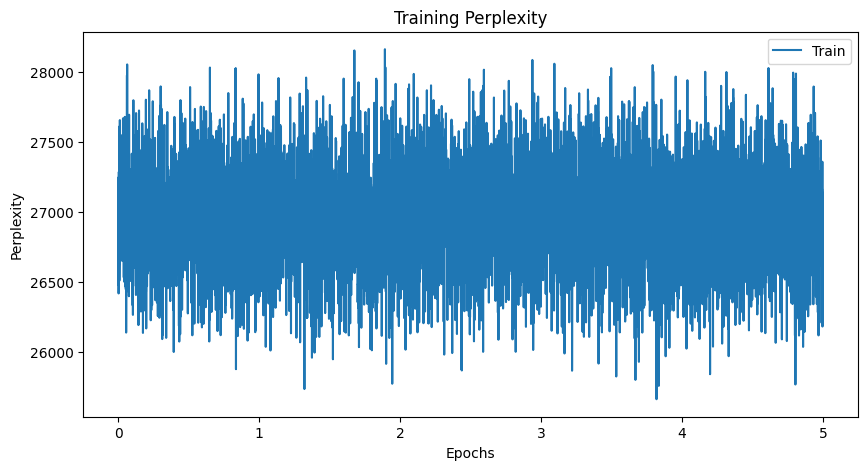

In [83]:
perplexity = []
for l in training_loss_logger:
    p = torch.exp(torch.tensor(l))
    perplexity.extend([p])

plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, nepochs, len(perplexity)), perplexity)

plt.legend(["Train"])
plt.title("Training Perplexity")
plt.xlabel("Epochs")
plt.ylabel("Perplexity")

plt.show()

In [20]:
testing_loss_logger = []
            
for epoch in trange(0, 1, leave=False, desc="Epoch"):    
    tf_generator.train()
    steps = 0
    for text in tqdm(data_loader_test, desc="Testing", leave=False):
        text_tokens = train_tranform(list(text))
        bs = text_tokens.shape[0]
        
        input_text = td(text_tokens[:, 0:-1])
        output_text = text_tokens[:, 1:]

        with torch.cuda.amp.autocast():
            pred = tf_generator(input_text)

        mask = (output_text != 0).float()
        loss = (loss_fn(pred.transpose(1, 2), output_text) * mask).sum()/mask.sum()
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        testing_loss_logger.append(loss.item())
        with torch.no_grad():
            dist = Categorical(logits=pred)
            entropy_logger.append(dist.entropy().mean().item())

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

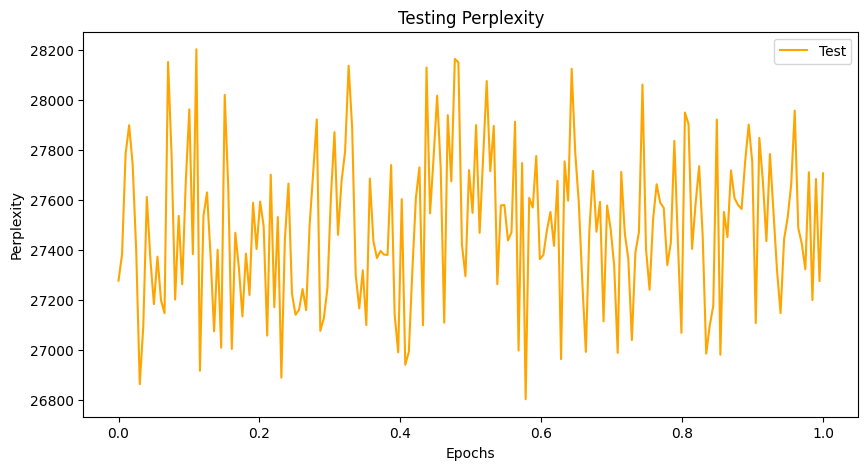

In [21]:
test_perplexity = []
for l in testing_loss_logger:
    p = torch.exp(torch.tensor(l))
    test_perplexity.extend([p])

plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, 1, len(test_perplexity)), test_perplexity, color='orange')

plt.legend(["Test"])
plt.title("Testing Perplexity")
plt.xlabel("Epochs")
plt.ylabel("Perplexity")

plt.show()